# Processing roadway maps into zone graphs

Goal of this tutorial:

1. Load the taxi zone data as polygons
2. Load the street map data as polylines
3. Figure out the connectivity of zones, i.e. for a given zone, which zones are directly accessible via a roadway without traveling into other zones.  Build a graph for that.

Luckily, `geopandas`, `shapely`, and `pyproj` will handle most of the geographic dirtiness for us.

## Load the geographic data

`geopandas` is simply an extension of `pandas` that can also process shape data, including polygons, polylines, etc.

Most of the geographic data you'll find are either in GeoJSON or Shapefile format.  Both of them can be processed using `geopandas`.

In [1]:
import geopandas

taxi_zones = geopandas.read_file('../data/taxi_zones.dbf')
streets = geopandas.read_file('../data/geo_export.dbf')

From the documentation of both datasets, we know that the coordinate systems are different: the Taxi Zones are in [a geographic coordinate system focusing on New York City](http://spatialreference.org/ref/esri/nad-1983-stateplane-new-york-long-island-fips-3104-feet/), while the street map data are in longitude and latitude.

Fortunately, `pyproj` is able to handle the transformation between two coordinate systems.  Here we will translate the New York coordinate system to latitude-longitude.

In [2]:
from functools import partial
from shapely.ops import transform as shapely_transform
import pyproj

proj_str = '+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs'

proj_src = pyproj.Proj(proj_str, preserve_units=True)
proj_dst = pyproj.Proj(init="epsg:4326")
proj_func = partial(pyproj.transform, proj_src, proj_dst)

taxi_zones['geometry'] = taxi_zones['geometry'].apply(lambda x: shapely_transform(proj_func, x))

For visualization, we can also pick a point inside each taxi zone.  Later on, we will superimpose a zone connectivity graph on the taxi zone plot itself.

In [3]:
taxi_zones['coords'] = taxi_zones['geometry'].apply(lambda x: x.representative_point().coords[0])

Now let's visualize stuff.

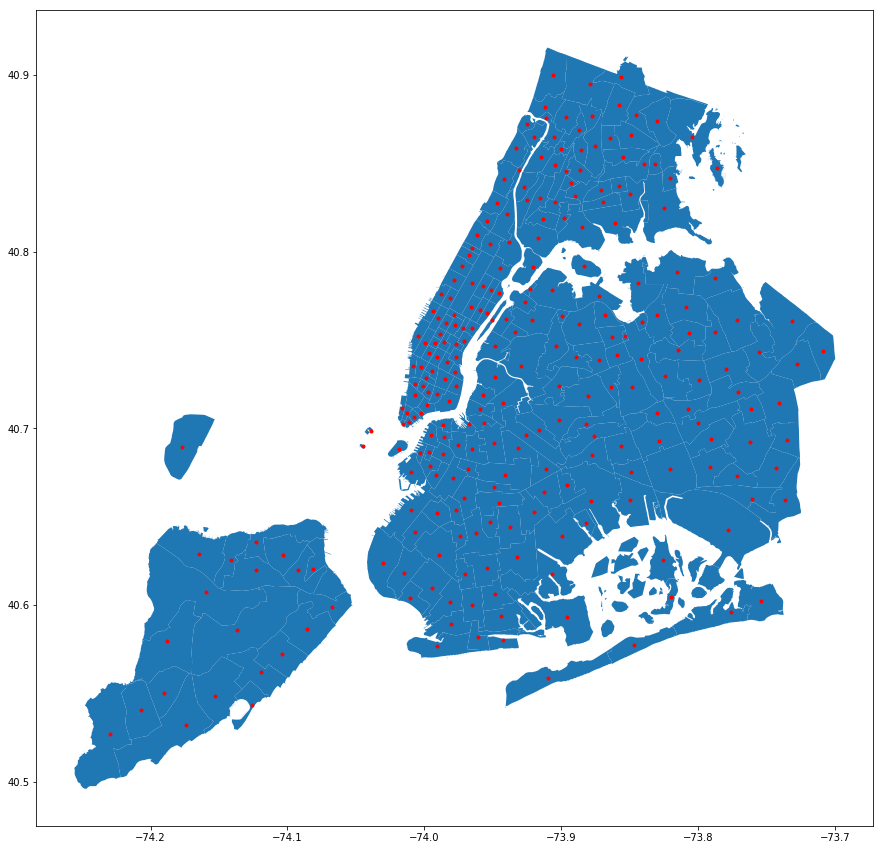

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
taxi_zones['geometry'].plot(ax=ax)
ax.scatter(*zip(*taxi_zones['coords']), marker='.', color='red')

From the documentation we know that some of the "streets" are actually ferry lanes and other types of routes.  We need to exclude them so only roadways (on land) are considered.

In [5]:
streets = streets[streets['rw_type'] <= 10].copy()

Now we put all the segments into a list, and all the endpoints into a set, so that the coordinates can be mapped into their zones.

Note that some of the coordinates may not lay in any zone (e.g. a point on a bridge).

In [6]:
import tqdm
import itertools
import numpy as np
import shapely.geometry as geom

segments = []
coord_set = set()
for street in tqdm.tqdm_notebook(streets.geometry):
    coords = list(street.coords)
    for i in range(len(coords) - 1):
        coord_x_0 = coords[i][0]
        coord_y_0 = coords[i][1]
        coord_x_1 = coords[i+1][0]
        coord_y_1 = coords[i+1][1]
        coord_0 = (coord_x_0, coord_y_0)
        coord_1 = (coord_x_1, coord_y_1)
        coord_set.add(coord_0)
        coord_set.add(coord_1)
        segments.append((coord_0, coord_1))

Let's see how the street map looks like.

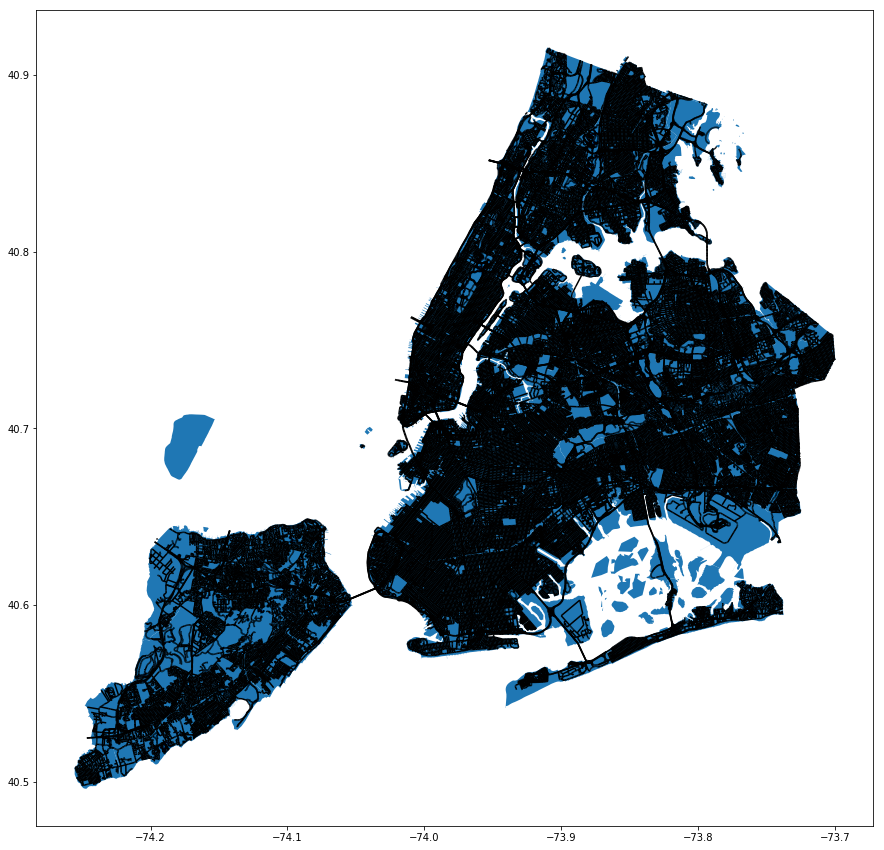

In [7]:
import matplotlib.collections as mc

fig = plt.figure(figsize=(15, 15))
taxi_zones['geometry'].plot(ax=fig.gca())
fig.gca().add_collection(mc.LineCollection(segments, colors='black'))

## Build zone connectivity graph



Right now, we can think that we have a graph with all distinct coordinates as nodes, and all the street segment as edges.  Now we try to coalesce the coordinates into zones.

First, for each endpoint, we need to find the taxi zone containing it.

In [8]:
coord_zone_map = {}
for coord in tqdm.tqdm_notebook(coord_set):
    coord_zone_map[coord] = taxi_zones.geometry.contains(geom.Point(coord)).nonzero()[0].tolist()

For each segment, if an endpoint lies in a taxi zone, we replace the endpoint with the node of that zone.

In [9]:
new_segs = set()
out_segs = []
out_segs_2 = []
for seg in tqdm.tqdm_notebook(segments):
    src, dst = seg
    src_zones, dst_zones = coord_zone_map[src], coord_zone_map[dst]
    if len(src_zones) > 0 and len(dst_zones) > 0:
        new_segs.update([(s, d) for s, d in itertools.product(src_zones, dst_zones)])
    elif len(src_zones) > 0:
        new_segs.update([(s, dst) for s in src_zones])
    elif len(dst_zones) > 0:
        new_segs.update([(src, d) for d in dst_zones])
    else:
        new_segs.update([(src, dst)])

Now we turn to a powerful graph package called `networkx`.  It is pretty flexible in terms of graph manipulation itself, and has a (kind of) pythonic syntax.

In [10]:
import networkx as nx

g = nx.Graph()
g.add_edges_from(new_segs)

For each node that is not in any of the zone, we remove it and connect all its neighbors pairwise.

In [11]:
anonymous_nodes = [n for n in g.nodes if isinstance(n, tuple)]
for n in tqdm.tqdm_notebook(anonymous_nodes):
    neighbors = list(g[n])
    g.remove_node(n)
    for n1, n2 in itertools.product(neighbors, neighbors):
        if n1 != n2:
            g.add_edge(n1, n2)

Let's see how the graph looks like:

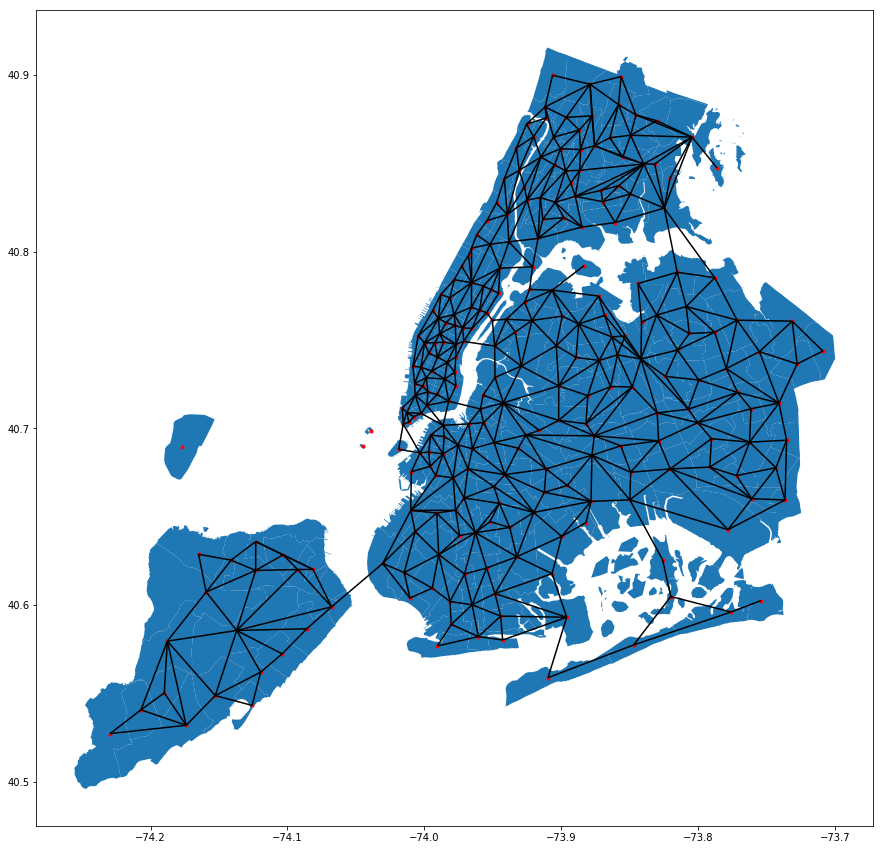

In [13]:
%matplotlib inline
lines = []
for u, v in g.edges:
    if not isinstance(u, int) or not isinstance(v, int):
        continue
        
    if u != v:
        lines.append((taxi_zones['coords'][u], taxi_zones['coords'][v]))
fig = plt.figure(figsize=(15, 15))
taxi_zones['geometry'].plot(ax=fig.gca())
new_seg_lines = [l for l in new_segs if isinstance(l[0], tuple)]
fig.gca().add_collection(mc.LineCollection(lines, colors='black'))
fig.gca().scatter(*zip(*taxi_zones['coords']), marker='.', color='r')